In [1]:
import os
import pandas as pd
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt
import re
import seaborn as sns

%matplotlib inline

## Data Cleaning & EDA

In [2]:
# import kickstarter data obtained from https://webrobots.io/kickstarter-datasets/ (2018-02-15 file)
# the data was unziped and merged into one file
df = pd.read_csv('../mcnulty_data/Kickstarter_2018-02-15T03_20_44_743Z.csv')

/home/ubuntu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195614 entries, 0 to 195613
Data columns (total 39 columns):
Unnamed: 0                  195614 non-null int64
index                       195614 non-null int64
backers_count               195614 non-null int64
blurb                       195603 non-null object
category                    195614 non-null object
converted_pledged_amount    195614 non-null int64
country                     195614 non-null object
created_at                  195614 non-null int64
creator                     195614 non-null object
currency                    195614 non-null object
currency_symbol             195614 non-null object
currency_trailing_code      195614 non-null bool
current_currency            195614 non-null object
deadline                    195614 non-null int64
disable_communication       195614 non-null bool
fx_rate                     195614 non-null float64
goal                        195614 non-null float64
id                          19

In [4]:
# drop columns that mostly have Nulls and old index columns
df.drop(labels=['Unnamed: 0','index','friends','is_backing','is_starred','permissions'],axis=1,inplace=True)

In [5]:
# since there is a lot of data: drop rows containing NULLs
df.dropna(axis=0, how='any',inplace=True)
len(df)

194037

In [6]:
df.state.unique()

array(['successful', 'live', 'canceled', 'failed', 'suspended'],
      dtype=object)

In [7]:
# keep only completed projects with state 'successful' and 'failed' to generate the y variable
df = df[(df['state']=='successful') | (df['state']=='failed')].copy()
len(df)

177976

In [8]:
# change [state] column name and turn into bool (so 'state' can be used for US states later)
df.rename(columns={'state':'project_success'},inplace=True)
df['project_success'] = np.where(df['project_success']=='successful', 1, 0)

In [9]:
# change columns containing time in epoch format to datetime
epoch_cols = ['created_at','deadline','launched_at','state_changed_at']
for col in epoch_cols:
    df[col] = [time.strftime('%Y-%m-%d', time.localtime(t)) for t in df[col]]
    df[col] = pd.to_datetime(df[col],format="%Y/%m/%d")

In [10]:
df[['created_at','deadline','launched_at','state_changed_at']].head(3)

,created_at,deadline,launched_at,state_changed_at
0,2012-01-07,2012-04-19,2012-03-28,2012-04-19
1,2012-03-02,2012-04-20,2012-03-28,2012-04-20
2,2012-03-24,2012-04-17,2012-03-28,2012-04-17


In [11]:
print(df.created_at.min())
print(df.created_at.max())

2009-04-22 00:00:00
2018-02-12 00:00:00


In [12]:
# see the range for project goals
df['goal'].describe()

count    1.779760e+05
mean     4.232395e+04
std      1.128140e+06
min      1.000000e-02
25%      1.500000e+03
50%      5.000000e+03
75%      1.200000e+04
max      1.000000e+08
Name: goal, dtype: float64

In [13]:
# there are projects with goal of $1. This analysis will focus on $500+ projects
df = df[df['goal']>=500].copy()
len(df)

165597

In [14]:
# create a column for a year when the project was launched
df['launch_year']=df['launched_at'].apply(lambda x: x.year)

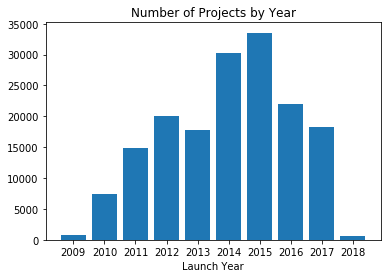

In [15]:
# plot number of projects launched every year
project_count_by_year = df.groupby(by='launch_year')['id'].count()

plt.bar(project_count_by_year.index, project_count_by_year.values)
plt.xlabel('Launch Year')
plt.xticks(project_count_by_year.index)
plt.title('Number of Projects by Year');

In [16]:
# focus analysis on just 2013_2017 projects in order to make the dataset more managable
df = df[(df['launch_year']>=2013) & (df['launch_year']<=2017)].copy()
len(df)

121810

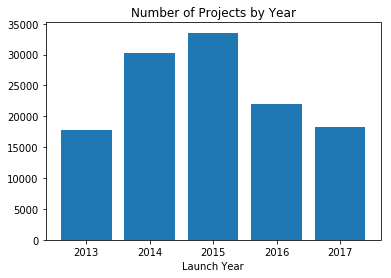

In [17]:
project_count_by_year_trimmed = df.groupby(by='launch_year')['id'].count()

plt.bar(project_count_by_year_trimmed.index, project_count_by_year_trimmed.values)
plt.xlabel('Launch Year')
plt.xticks(project_count_by_year_trimmed.index)
plt.title('Number of Projects by Year');

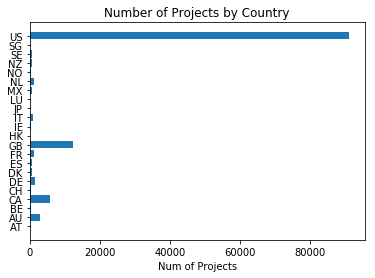

In [18]:
# check project count distribution by country
project_by_country = df.groupby(by='country')['id'].count()

plt.barh(project_by_country.index,project_by_country.values)
plt.xlabel('Num of Projects')
plt.title('Number of Projects by Country');

In [19]:
# focus analysis only on the US projects
df = df[df['country']=='US'].copy()
df.drop('country',axis=1,inplace=True)
len(df)

90850

In [20]:
# location contans contries that are non-US
# make sure that country was note misclassified in [country] field

df['country_check'] = [re.match(r'.+("country":)("\w\w").+', loc_string).group(2).replace('"','') for loc_string in df['location']]
df = df[df['country_check']=='US'].copy()
df.drop('country_check',axis=1,inplace=True)
len(df)

87456

In [21]:
# create US state column
df['state'] = [re.match(r'.+("state":)("\w+").+', loc_string).group(2).replace('"','') 
               for loc_string in df['location']]

df.state.unique()

array(['PA', 'CA', 'MS', 'FL', 'VA', 'TX', 'NV', 'AL', 'LA', 'NY', 'OH',
       'WA', 'AZ', 'IN', 'AK', 'MT', 'NJ', 'VT', 'IA', 'WI', 'ME', 'NC',
       'TN', 'SC', 'KS', 'GA', 'MN', 'OR', 'MD', 'NH', 'HI', 'OK', 'CO',
       'MA', 'IL', 'AR', 'MO', 'ND', 'DC', 'NM', 'UT', 'MI', 'NE', 'CT',
       'KY', 'RI', 'ID', 'DE', 'WV', 'WY', 'SD'], dtype=object)

In [22]:
# see what category var looks
df.loc[2109,'category']

'{"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/art/ceramics"}},"color":16760235,"parent_id":1,"name":"Ceramics","id":287,"position":1,"slug":"art/ceramics"}'

In [23]:
# extract general category
df['gen_category'] = [cat_string.split('"')[-2].split('/')[0] for cat_string in df['category']]
df['gen_category'].unique()

array(['art', 'comics', 'crafts', 'dance', 'design', 'fashion',
       'film & video', 'food', 'games', 'journalism', 'music',
       'photography', 'publishing', 'technology', 'theater'], dtype=object)

In [24]:
# extract subcategory
df['sub_category'] = [cat_string.split('"')[-2].split('/')[-1] for cat_string in df['category']]
df['sub_category'].unique()

array(['ceramics', 'conceptual art', 'illustration', 'installations',
       'digital art', 'mixed media', 'painting', 'performance art',
       'public art', 'sculpture', 'comics', 'comic books', 'webcomics',
       'graphic novels', 'anthologies', 'textiles', 'video art', 'events',
       'crafts', 'diy', 'woodworking', 'knitting', 'printing', 'quilts',
       'stationery', 'crochet', 'candles', 'pottery', 'embroidery',
       'glass', 'weaving', 'taxidermy', 'performances', 'residencies',
       'spaces', 'dance', 'workshops', 'product design', 'design',
       'graphic design', 'civic design', 'architecture', 'typography',
       'accessories', 'interactive design', 'apparel', 'footwear',
       'jewelry', 'pet fashion', 'ready-to-wear', 'childrenswear',
       'couture', 'action', 'animation', 'comedy', 'drama', 'festivals',
       'experimental', 'family', 'horror', 'movie theaters',
       'music videos', 'narrative film', 'fantasy', 'romance',
       'science fiction', 'televis

In [25]:
# now that we have gen- and sub-category we can get rid of raw category field
df.drop(labels=['category'],axis=1,inplace=True)

In [26]:
# check for duplicate values 
dups = df[df.duplicated(subset='id',keep=False)==True].copy()
print('Number of duplicated project IDs:', len(dups.groupby('id')))

Number of duplicated project IDs: 4091


In [27]:
# drop all duplicates completelly (including first/last)
# It's not worth the time to figure out which ones to keep since the dataset is big enough
df = df[df.duplicated(subset='id',keep=False)==False].copy()
len(df)

79273

In [28]:
# calculate project length 
df['project_length'] = (df['deadline'] - df['launched_at']).dt.days
df['project_length'].mean()

32.945000189219535

In [29]:
# add days till status change
df['status_changed_days'] = (df['state_changed_at'] - df['launched_at']).dt.days
df['status_changed_days'].mean()

32.94534078437803

In [30]:
# check variance in each column of the dataset

df_cols = list(df.columns)

for c in df_cols:
    print(c, len(set(df[c])))

backers_count 2201
blurb 78806
converted_pledged_amount 20113
created_at 2236
creator 79141
currency 1
currency_symbol 1
currency_trailing_code 1
current_currency 1
deadline 1857
disable_communication 1
fx_rate 1
goal 2905
id 79273
is_starrable 1
launched_at 1826
name 79156
photo 79273
pledged 23656
profile 79273
slug 79273
source_url 161
spotlight 2
staff_pick 2
project_success 2
state_changed_at 1857
static_usd_rate 1
urls 79273
usd_pledged 23656
usd_type 1
location 8946
launch_year 5
state 51
gen_category 15
sub_category 151
project_length 66
status_changed_days 66


In [31]:
# drop columns that have no variance
df.drop(labels=['currency','currency_symbol','currency_trailing_code','current_currency','disable_communication',
               'fx_rate','is_starrable','static_usd_rate','usd_type'],axis=1,inplace=True)

In [32]:
# check if converted_pleged_amonth and usd_pledged is the same var
df[['converted_pledged_amount','usd_pledged']].corr()

,converted_pledged_amount,usd_pledged
converted_pledged_amount,1.0,1.0
usd_pledged,1.0,1.0


### Import monthly Consumer Confidence Index data 
- Source: Organisation for Economic Co-operation and Development

In [33]:
cci = pd.read_csv('../mcnulty_data/usa_cci.csv')
cci.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,USA,CCI,AMPLITUD,LTRENDIDX,M,2009-01,96.72424
1,USA,CCI,AMPLITUD,LTRENDIDX,M,2009-02,96.69838
2,USA,CCI,AMPLITUD,LTRENDIDX,M,2009-03,96.89890
3,USA,CCI,AMPLITUD,LTRENDIDX,M,2009-04,97.34391
4,USA,CCI,AMPLITUD,LTRENDIDX,M,2009-05,97.72681


In [34]:
cci['TIME'] = pd.to_datetime(cci['TIME'],format="%Y/%m")
cci['year'] = cci['TIME'].apply(lambda x: x.year)
cci['month'] = cci['TIME'].apply(lambda x: x.month)

In [35]:
cci['Value'].describe()

count    110.000000
mean      99.359164
std        1.324061
min       96.698380
25%       98.388845
50%       99.216125
75%      100.606750
max      101.401900
Name: Value, dtype: float64

In [36]:
cci_clean = cci[['Value','year','month']].copy()
cci_clean.rename(columns={"Value": "cci"}, inplace = True)

In [37]:
# create columns to append cci on

df['launch_month']=df['launched_at'].apply(lambda x: x.month)
df['deadline_year']=df['deadline'].apply(lambda x: x.year)
df['deadline_month']=df['deadline'].apply(lambda x: x.month)

In [38]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at',
       'creator', 'deadline', 'goal', 'id', 'launched_at', 'name', 'photo',
       'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick',
       'project_success', 'state_changed_at', 'urls', 'usd_pledged',
       'location', 'launch_year', 'state', 'gen_category', 'sub_category',
       'project_length', 'status_changed_days', 'launch_month',
       'deadline_year', 'deadline_month'],
      dtype='object')

In [39]:
# join cci with df
df = df.merge(cci_clean, left_on = ['launch_year','launch_month'], right_on = ['year','month'],how='left').copy()
# rename cci
df.rename(columns={'cci':'launch_cci'},inplace=True)

In [40]:
df = df.merge(cci_clean, left_on = ['deadline_year','deadline_month'], right_on = ['year','month'],how='left').copy()
# rename cci
df.rename(columns={'cci':'deadline_cci'},inplace=True)

In [41]:
df['mean_cci'] = (df['launch_cci'] + df['deadline_cci'])/2

In [42]:
df.drop(labels=[
    'deadline_year',
    'deadline_month',
    'launch_month',
    'year_x', 
    'month_x',
    'year_y', 
    'month_y',
    'deadline_cci'],
        axis=1,inplace=True)

### Use VADER  to test blurbs
(Valence Aware Dictionary and sEntiment Reasoner)

In [43]:
# !pip install vaderSentiment

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [45]:
# create [positive] and [compound] blurb sentiment scores
analyzer = SentimentIntensityAnalyzer()

df['blurb_pos'] = [analyzer.polarity_scores(blurb)['pos'] for blurb in df['blurb']]
df['blurb_compound'] = [analyzer.polarity_scores(blurb)['compound'] for blurb in df['blurb']]
df[['blurb_pos','blurb_compound']].describe()

,blurb_pos,blurb_compound
count,79273.000000,79273.000000
mean,0.167627,0.317832
std,0.143244,0.424292
min,0.000000,-0.973800
25%,0.000000,0.000000
50%,0.152000,0.401900
75%,0.264000,0.670500
max,1.000000,0.983700


### Get Number of Reward Levels data

In [46]:
# see [urls] field example
df.loc[0]['urls']

'{"web":{"project":"https://www.kickstarter.com/projects/2097219279/pottery-studio-build-and-kiln?ref=category_newest","rewards":"https://www.kickstarter.com/projects/2097219279/pottery-studio-build-and-kiln/rewards"}}'

In [47]:
# create a function to extract the rewards url from [urls]
def rewards_url(urls_string):
    r_url = re.match(r'.+("rewards":)("https://www.kickstarter.com.*/rewards").+',urls_string).group(2).replace('"','') 
    return(r_url)

In [48]:
df['rewards_url'] = [rewards_url(url_string) for url_string in df['urls']]

In [49]:
# create a file with urls for reward scraping
rewards_df = df[['id','rewards_url']].copy()

In [50]:
rewards_df.head()

,id,rewards_url
0,397813329,https://www.kickstarter.com/projects/209721927...
1,1079930054,https://www.kickstarter.com/projects/141670531...
2,1146086992,https://www.kickstarter.com/projects/129761750...
3,1847095535,https://www.kickstarter.com/projects/122214150...
4,756870088,https://www.kickstarter.com/projects/127715372...


In [51]:
# create a file to use for scraping
rewards_df.to_csv('../mcnulty_data/rewards_df.csv')

#### Go scrape! (see notebook: kickstarter_scraper_beatifulsoup.ipynb)

In [52]:
# import scraped kickstarter data

dfs = []
for file_num in np.arange(0,33):
    file_name = f'../mcnulty_data/scraped/kickstarter_project_reward_count_{file_num}.csv'
    dfs.append(
        pd.read_csv(file_name)
    )

In [53]:
# combine all csv's into one df
ks_rewards = pd.concat(dfs).reset_index()
# check for duplicates
ks_rewards = ks_rewards[ks_rewards.duplicated(subset='id',keep='first')==False].copy()
ks_rewards = ks_rewards[['id','rewards_count']].copy()
ks_rewards.head()

,id,rewards_count
0,1414438580,14
1,1597422030,1
2,427587316,10
3,269813328,9
4,1047446912,4


In [54]:
df = df.merge(ks_rewards, on='id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79273 entries, 0 to 79272
Data columns (total 34 columns):
backers_count               79273 non-null int64
blurb                       79273 non-null object
converted_pledged_amount    79273 non-null int64
created_at                  79273 non-null datetime64[ns]
creator                     79273 non-null object
deadline                    79273 non-null datetime64[ns]
goal                        79273 non-null float64
id                          79273 non-null int64
launched_at                 79273 non-null datetime64[ns]
name                        79273 non-null object
photo                       79273 non-null object
pledged                     79273 non-null float64
profile                     79273 non-null object
slug                        79273 non-null object
source_url                  79273 non-null object
spotlight                   79273 non-null bool
staff_pick                  79273 non-null bool
project_success       

In [55]:
# there are two rows missing reward_count values, drop those
df.dropna(axis=0, how='any',inplace=True)
len(df)

79271

### Get count of projects per project creator

In [56]:
# see what creator values look like 
df.loc[0]['creator']

'{"urls":{"web":{"user":"https://www.kickstarter.com/profile/2097219279"},"api":{"user":"https://api.kickstarter.com/v1/users/2097219279?signature=1518793840.bb8d56e6a80230feacd3a4fa7cdb91697dfc212f"}},"is_registered":true,"chosen_currency":null,"name":"Ryan Moore","id":2097219279,"avatar":{"small":"https://ksr-ugc.imgix.net/assets/010/742/833/f72b2d477ba86a698dac006ac7cf68d8_original.PNG?w=160&h=160&fit=crop&v=1506889366&auto=format&q=92&s=179ee0aa5c0f334e53047d83c3f8f87e","thumb":"https://ksr-ugc.imgix.net/assets/010/742/833/f72b2d477ba86a698dac006ac7cf68d8_original.PNG?w=40&h=40&fit=crop&v=1506889366&auto=format&q=92&s=7756ad34f1816655d7cf89c28b646242","medium":"https://ksr-ugc.imgix.net/assets/010/742/833/f72b2d477ba86a698dac006ac7cf68d8_original.PNG?w=160&h=160&fit=crop&v=1506889366&auto=format&q=92&s=179ee0aa5c0f334e53047d83c3f8f87e"}}'

In [57]:
# extract creator id
df['creator_id'] = [re.match(r'.+("id":)(\d+,).+',creator).group(2).replace(',','') 
                    for creator in df['creator']]

In [58]:
creator_dups = df[df.duplicated(subset='creator_id',keep=False)==True].copy()
print('Number of duplicated project IDs:', len(creator_dups.groupby('creator_id')))

Number of duplicated project IDs: 5164


In [59]:
# assign a count for each project created by the same creator_id
df.sort_values(by=['creator_id','launched_at'],inplace=True)

df['proj_num_by_creator'] = df.groupby(['creator_id']).cumcount()+1

In [60]:
df['proj_num_by_creator'].describe()

count    79271.000000
mean         1.213622
std          1.410348
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
Name: proj_num_by_creator, dtype: float64

In [61]:
# to avoide creating categorical var for the count of projects, 
# create a binary var: first project non-first
df['first_time_proj'] = np.where(df['proj_num_by_creator']==1, 1, 0)

## EDA

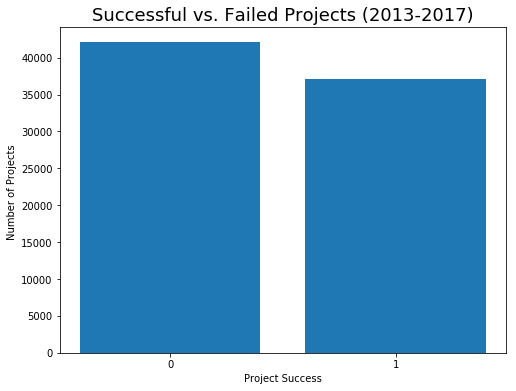

In [62]:
# check the ratio of successful and failed projects
plt.figure(figsize=(8,6))

plt.bar(df.groupby('project_success')['id'].count().index, df.groupby('project_success')['id'].count().values)
plt.xlabel('Project Success')
plt.xticks(df.groupby('project_success')['id'].count().index)
plt.ylabel('Number of Projects ')
plt.title('Successful vs. Failed Projects (2013-2017)', size = 18);

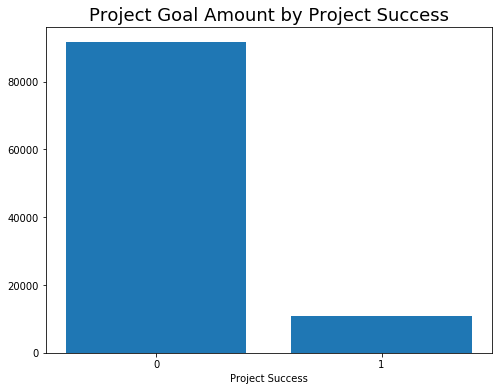

In [63]:
goal_by_success = df.groupby(by='project_success')['goal'].mean()

plt.figure(figsize=(8,6))

plt.bar(goal_by_success.index, goal_by_success.values)
plt.xlabel('Project Success')
plt.xticks(goal_by_success.index)
plt.title('Project Goal Amount by Project Success', size = 18);

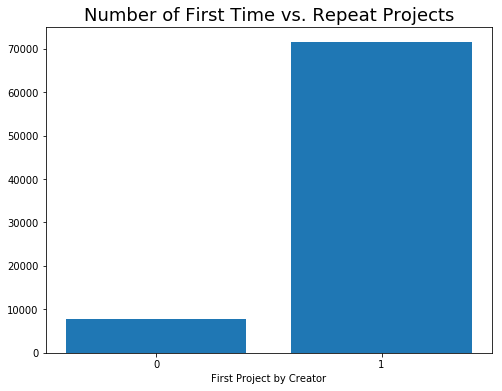

In [64]:
# ratio of first time to non-first time projects

first_time_vs_repeat = df.groupby(by='first_time_proj')['id'].count()

plt.figure(figsize=(8,6))

plt.bar(first_time_vs_repeat.index, first_time_vs_repeat.values)
plt.xlabel('First Project by Creator')
plt.xticks(first_time_vs_repeat.index)
plt.title('Number of First Time vs. Repeat Projects', size = 18);

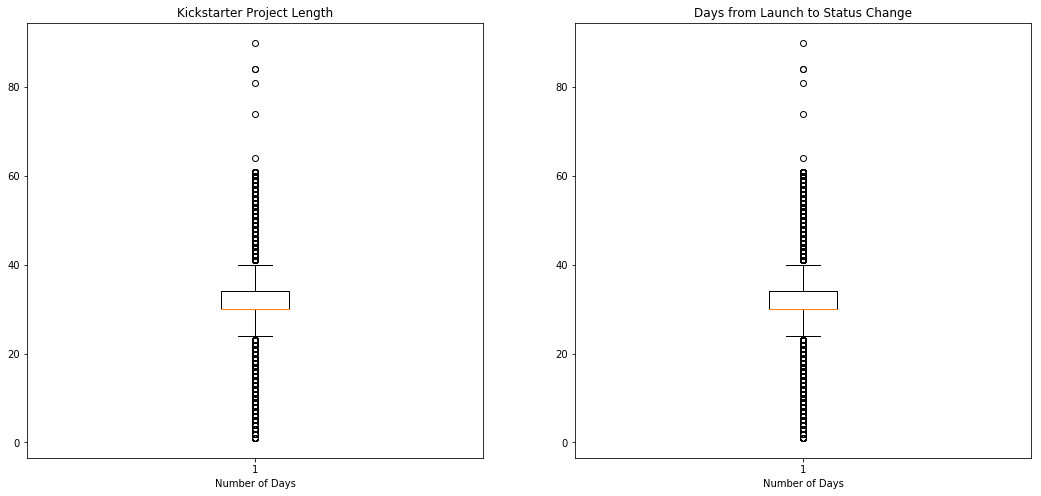

In [65]:
# check project length distribution
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.boxplot(df['project_length'])
plt.title('Kickstarter Project Length')
plt.xlabel('Number of Days')

plt.subplot(1, 2, 2)
plt.boxplot(df['status_changed_days'])
plt.title('Days from Launch to Status Change')
plt.xlabel('Number of Days');

### Observation:
- It looks like project length and days till status change are the same/very similar => Will use only one in the model

#### Project Categories

In [66]:
print('Number of gen categoreis: ', len(np.unique(df['gen_category'])))
print('Number of sub categoreis: ', len(np.unique(df['sub_category'])))

Number of gen categoreis:  15
Number of sub categoreis:  151


In [67]:
# get list of gen_categories
gen_categories = list(set(df['gen_category']))

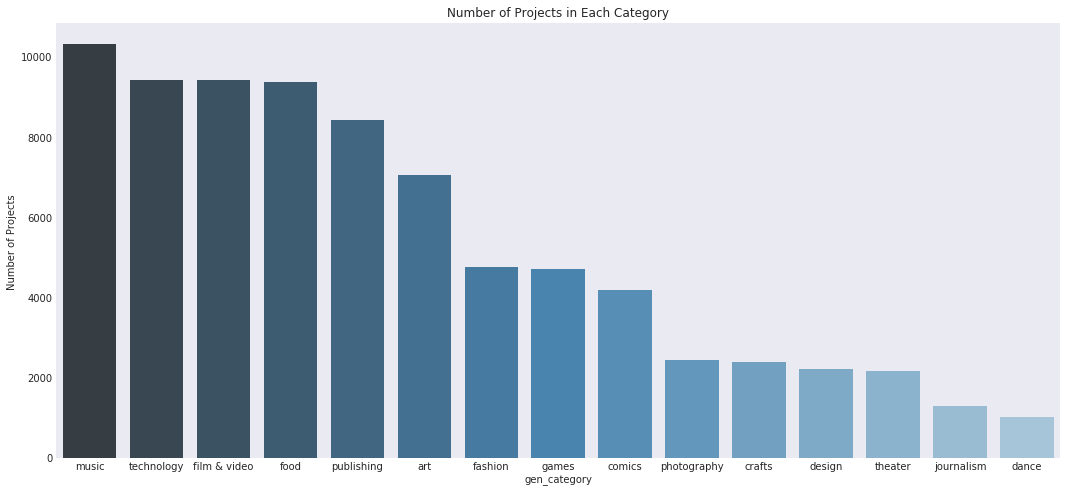

In [68]:
# plot bar chart with gen_categories 
category_count_sorted = df.groupby('gen_category')['id'].count().sort_values(ascending=False).reset_index().copy()

plt.figure(figsize=(18, 8))

sns.set_style("dark")
sns.barplot(category_count_sorted['gen_category'], category_count_sorted['id'], palette="Blues_d")
plt.ylabel('Number of Projects ')
plt.title('Number of Projects in Each Category');

In [69]:
# create categorical variables based on ['gen_category'] column. 
# wait on creating sub_category features for now since there are very many
df = pd.get_dummies(df, columns=['gen_category'], prefix='category')
df.rename(columns={'category_film & video':'category_film_n_video'},inplace=True)

In [70]:
# update gen_category list
gen_categories[gen_categories.index('film & video')] = 'film_n_video'
gen_categories = ['category_'+ cat for cat in gen_categories]

Text(0.5,1,'Consumer Confidence Index 2013-2017')

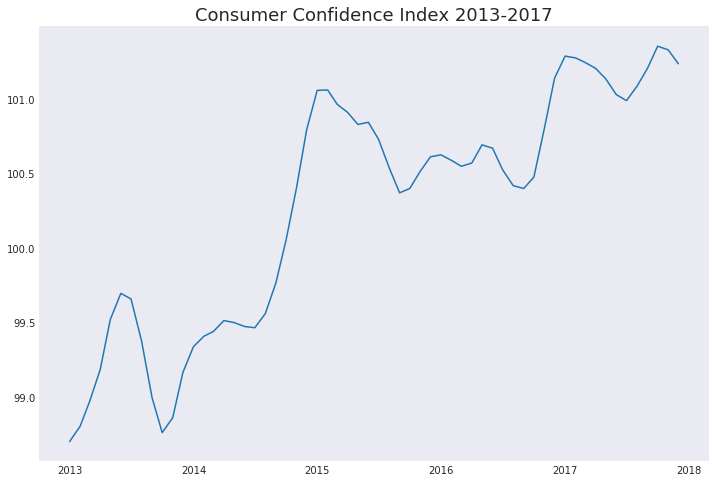

In [71]:
# CCI index timeseries
cci_13_17 = cci[(cci['TIME']>='2013-01-01') & (cci['TIME']<'2018-01-01')]

plt.figure(figsize=(12,8))
plt.plot(cci_13_17['TIME'], cci_13_17['Value'])
plt.title('Consumer Confidence Index 2013-2017', size=18)

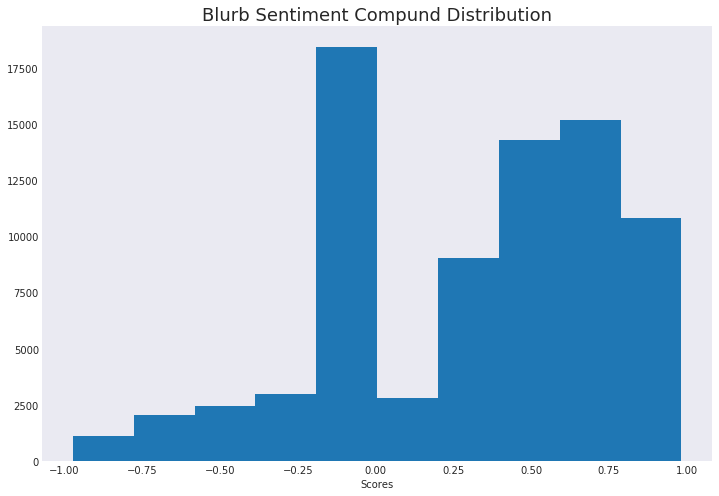

In [72]:
plt.figure(figsize=(12, 8))

plt.hist(df['blurb_compound'])
plt.title('Blurb Sentiment Compund Distribution', size=18)
plt.xlabel('Scores');

In [73]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at',
       'creator', 'deadline', 'goal', 'id', 'launched_at', 'name', 'photo',
       'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick',
       'project_success', 'state_changed_at', 'urls', 'usd_pledged',
       'location', 'launch_year', 'state', 'sub_category', 'project_length',
       'status_changed_days', 'launch_cci', 'mean_cci', 'blurb_pos',
       'blurb_compound', 'rewards_url', 'rewards_count', 'creator_id',
       'proj_num_by_creator', 'first_time_proj', 'category_art',
       'category_comics', 'category_crafts', 'category_dance',
       'category_design', 'category_fashion', 'category_film_n_video',
       'category_food', 'category_games', 'category_journalism',
       'category_music', 'category_photography', 'category_publishing',
       'category_technology', 'category_theater'],
      dtype='object')

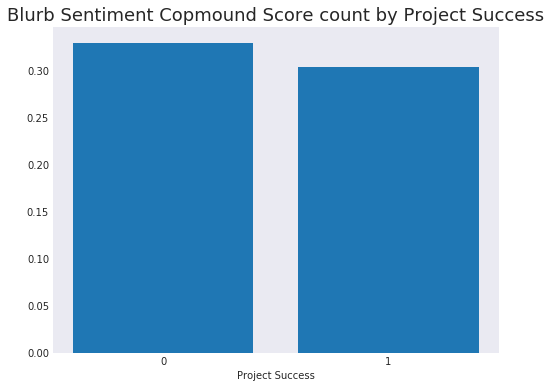

In [74]:
sentiment_by_success = df.groupby(by='project_success')['blurb_compound'].mean()

plt.figure(figsize=(8,6))

plt.bar(sentiment_by_success.index, sentiment_by_success.values)
plt.xlabel('Project Success')
plt.xticks(sentiment_by_success.index)
plt.title('Blurb Sentiment Copmound Score count by Project Success', size = 18);

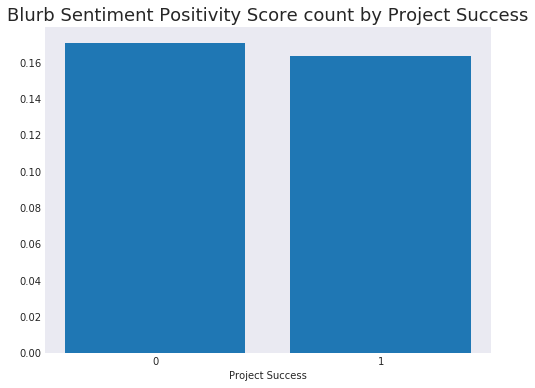

In [75]:
pos_sentiment_by_success = df.groupby(by='project_success')['blurb_pos'].mean()

plt.figure(figsize=(8,6))

plt.bar(pos_sentiment_by_success.index, pos_sentiment_by_success.values)
plt.xlabel('Project Success')
plt.xticks(pos_sentiment_by_success.index)
plt.title('Blurb Sentiment Positivity Score count by Project Success', size = 18);

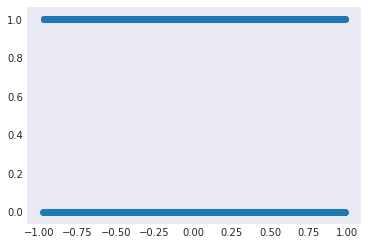

In [76]:
plt.scatter(df['blurb_compound'], df['project_success'])

In [77]:
df.groupby('project_success')['mean_cci'].mean()

project_success
0    100.433812
1    100.189986
Name: mean_cci, dtype: float64

In [78]:
df.groupby('project_success')['launch_cci'].mean()

project_success
0    100.407051
1    100.166753
Name: launch_cci, dtype: float64

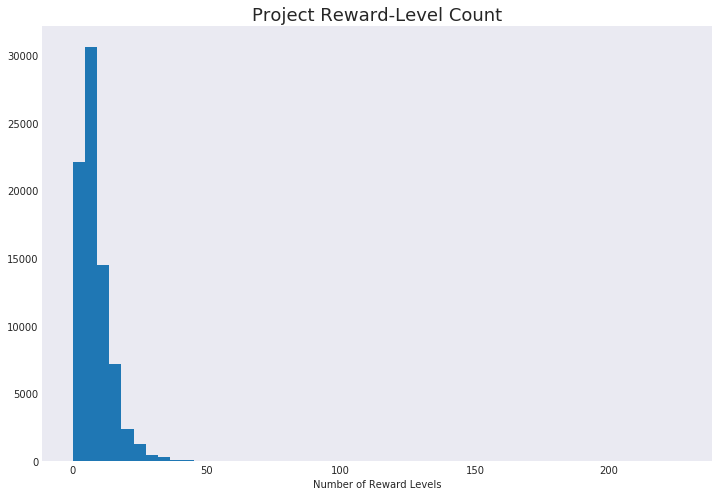

In [79]:
plt.figure(figsize=(12, 8))

plt.hist(df['rewards_count'],bins=50)
plt.title('Project Reward-Level Count', size=18)
plt.xlabel('Number of Reward Levels');

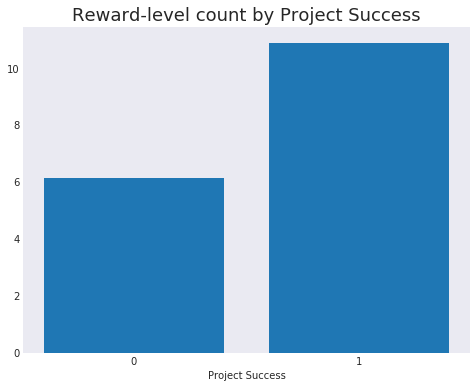

In [80]:
rewards_by_success = df.groupby(by='project_success')['rewards_count'].mean()

plt.figure(figsize=(8,6))

plt.bar(rewards_by_success.index, rewards_by_success.values)
plt.xlabel('Project Success')
plt.xticks(rewards_by_success.index)
plt.title('Reward-level count by Project Success', size = 18);

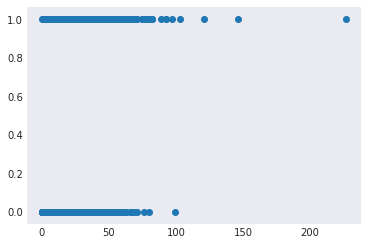

In [81]:
plt.scatter(df['rewards_count'], df['project_success'])

## Modeling

In [82]:
from sklearn import naive_bayes
from sklearn import pipeline, preprocessing, neighbors, model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [83]:
# create X and y variables
X = df.select_dtypes(exclude=object).drop('project_success',axis=1).copy()
y = df['project_success']

In [84]:
# experimentation setup

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


# transformation
scaler = preprocessing.StandardScaler()

# set cross-validation method
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=101)

In [85]:
# create a function to generate scaled X features
def get_X_std(df, feature_list):
    
    X = df[feature_list]  
    X_std = scaler.fit_transform(X)
    return(X_std)

### Establish a baseline for the models

In [86]:
# accuracy if we jsut did majority vote
baseline = round(y_test.value_counts().head(1) / len(y_test), 3)
print('Model baseline:', baseline.values)

Model baseline: [0.537]


In [87]:
# create a dataframe to keep track of all scores
model_results = pd.DataFrame(columns=['model','test_accuracy'])

def fill_in_res(model_name, test_accuracy):
    model_results.loc[len(model_results)]=[model_name,round(test_accuracy,3)] 
    return(model_results)

In [88]:
fill_in_res('Baseline', 0.537)

,model,test_accuracy
0,Baseline,0.537


### 1. Logistic Regression - Initial set of Features

In [89]:
# for testing only select features that have variance or bool
# not including 'usd_pleged' as it is a direct indicator on whether a project is succesfull or not 
# [spotlight] - only successuly funded projects get into spotlight, thus this variable will not be included
# backers count countains information that is not available at project launch => should not be included in the analysis

# first test logistic with the features that were originally available in the dataset
features = ['goal','staff_pick','project_length']

In [90]:
# generate X train and test
X_train_std_1 = get_X_std(X_train, features)
X_test_std_1 = get_X_std(X_test, features)

In [91]:
# test different C values on logistics regression
parameters = {'C': np.arange(0.001, 10, 0.5)}
logr = LogisticRegression(random_state = 101) 
log_model_1 = GridSearchCV(logr, parameters,cv=kfold)
log_model_1.fit(X_train_std_1, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00,
       3.001e+00, 3.501e+00, 4.001e+00, 4.501e+00, 5.001e+00, 5.501e+00,
       6.001e+00, 6.501e+00, 7.001e+00, 7.501e+00, 8.001e+00, 8.501e+00,
       9.001e+00, 9.501e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [92]:
log_model_1.best_params_

{'C': 9.501}

In [93]:
log_model_1.best_score_

0.6360486434662674

In [94]:
best_log_1 = log_model_1.best_estimator_
# check performace on test
best_log_1.score(X_test_std_1, y_test)

0.6348773841961853

In [95]:
fill_in_res('Log_reg: three base features', best_log_1.score(X_test_std_1, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635


### 2. Logistic Regression - Add [rewards_count] feature

In [96]:
features = ['goal',
 'staff_pick',
 'project_length',
 'rewards_count']

In [97]:
# generate x train and test
X_train_std_2 = get_X_std(X_train, features)
X_test_std_2 = get_X_std(X_test, features)

In [98]:
# test different C values on logistics regression
parameters = {'C': np.arange(0.001, 10, 0.5)}
logr = LogisticRegression(random_state = 101) 
log_model_2 = GridSearchCV(logr, parameters,cv=kfold)
log_model_2.fit(X_train_std_2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00,
       3.001e+00, 3.501e+00, 4.001e+00, 4.501e+00, 5.001e+00, 5.501e+00,
       6.001e+00, 6.501e+00, 7.001e+00, 7.501e+00, 8.001e+00, 8.501e+00,
       9.001e+00, 9.501e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
log_model_2.best_params_

{'C': 9.501}

In [100]:
log_model_2.best_score_

0.731704035120179

In [101]:
best_log_2 = log_model_2.best_estimator_
# check performace on test
best_log_2.score(X_test_std_2, y_test)

0.7451811484509032

#### Observation:
- Adding reward-level count increased accuracy level by 11% 

In [102]:
fill_in_res('Log_reg: with rewards_count', best_log_2.score(X_test_std_2, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745


### 3. Logistic Regression: test ALL features to identify the most important ones

In [103]:
# test all features with RandomForest
features = ['goal','staff_pick','project_length','rewards_count','first_time_proj','launch_cci','blurb_compound']
# add categories to features
features.extend(gen_categories)

In [104]:
# generate x train and test
X_train_std_3 = get_X_std(X_train, features)
X_test_std_3 = get_X_std(X_test, features)

In [105]:
# test different C values on logistics regression
parameters = {'C': np.arange(0.001, 10, 0.5)}
logr = LogisticRegression(random_state = 101) 
log_model_3 = GridSearchCV(logr, parameters,cv=kfold)
log_model_3.fit(X_train_std_3, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00,
       3.001e+00, 3.501e+00, 4.001e+00, 4.501e+00, 5.001e+00, 5.501e+00,
       6.001e+00, 6.501e+00, 7.001e+00, 7.501e+00, 8.001e+00, 8.501e+00,
       9.001e+00, 9.501e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
log_model_3.best_params_

{'C': 9.501}

In [107]:
log_model_3.best_score_

0.7565808285536474

In [108]:
best_log_3 = log_model_3.best_estimator_
# check performace on test
best_log_3.score(X_test_std_3, y_test)

0.7592592592592593

In [109]:
fill_in_res('Log_reg: with ALL features', best_log_3.score(X_test_std_3, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759


In [110]:
# check log_model coefficients
best_log_coefs = pd.DataFrame({'features': features, 'coefficients': best_log_3.coef_[0]})
best_log_coefs['exp_coef'] = [np.exp(coef) for coef in best_log_coefs['coefficients']]
best_log_coefs['abs_coef'] = [abs(coef) for coef in best_log_coefs['coefficients']]

best_log_coefs.sort_values('abs_coef',ascending = False, inplace=True)
best_log_coefs.drop(labels=['abs_coef'],axis=1).reset_index()

,index,coefficients,features,exp_coef
0,0,-26.585399,goal,2.845168e-12
1,3,1.052229,rewards_count,2.864028e+00
2,1,0.619146,staff_pick,1.857341e+00
3,20,0.253837,category_publishing,1.288961e+00
4,2,-0.249232,project_length,7.793992e-01
5,4,-0.220063,first_time_proj,8.024682e-01
6,13,-0.219500,category_journalism,8.029204e-01
7,5,-0.216541,launch_cci,8.052997e-01
8,8,0.184915,category_music,1.203116e+00
9,9,-0.182537,category_crafts,8.331540e-01


#### Observations:
- Among features non-related to project category blurb compound has rather low coefficeint that indicated it does not have much effect on the odds of project success. This aligns with what we saw on the scatter plot above.
- The majority of categories appear to have little effect on success odds as well

### 4. Logistic Regression on top 10 features

In [111]:
features = list(best_log_coefs['features'].head(10))

In [112]:
# generate x train and test
X_train_std_4 = get_X_std(X_train, features)
X_test_std_4 = get_X_std(X_test, features)

In [113]:
# test different C values on logistics regression
parameters = {'C': np.arange(0.001, 10, 0.5)}
logr = LogisticRegression(random_state = 101) 
log_model_4 = GridSearchCV(logr, parameters,cv=kfold)
log_model_4.fit(X_train_std_4, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00,
       3.001e+00, 3.501e+00, 4.001e+00, 4.501e+00, 5.001e+00, 5.501e+00,
       6.001e+00, 6.501e+00, 7.001e+00, 7.501e+00, 8.001e+00, 8.501e+00,
       9.001e+00, 9.501e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [114]:
log_model_4.best_params_

{'C': 7.501}

In [115]:
log_model_4.best_score_

0.7521908061830354

In [116]:
best_log_4 = log_model_4.best_estimator_
# check performace on test
best_log_4.score(X_test_std_4, y_test)

0.7558280351195883

In [117]:
fill_in_res('Log_reg: top 10 features', best_log_4.score(X_test_std_4, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756


In [118]:
# check log_model coefficients
best_log_coefs = pd.DataFrame({'features': features, 'coefficients': best_log_4.coef_[0]})
best_log_coefs['exp_coef'] = [np.exp(coef) for coef in best_log_coefs['coefficients']]
best_log_coefs['abs_coef'] = [abs(coef) for coef in best_log_coefs['coefficients']]

best_log_coefs.sort_values('abs_coef',ascending = False, inplace=True)
best_log_coefs.drop(labels=['abs_coef'],axis=1).reset_index()

,index,coefficients,features,exp_coef
0,0,-28.455950,goal,4.382661e-13
1,1,1.067900,rewards_count,2.909263e+00
2,2,0.614701,staff_pick,1.849105e+00
3,3,0.288742,category_publishing,1.334748e+00
4,4,-0.255670,project_length,7.743974e-01
5,5,-0.237409,first_time_proj,7.886685e-01
6,7,-0.225388,launch_cci,7.982065e-01
7,8,0.220414,category_music,1.246593e+00
8,6,-0.204041,category_journalism,8.154293e-01
9,9,-0.165313,category_crafts,8.476283e-01


#### Obesrvations:

- A standard deviation increase in project length reduces odds of a project being successful by ~ 22.6%
- A standard deviation increase in consumer confidence index at project launch reduces odds of a project being successful by ~ 20.2%. This does not seem intuitive, however, it could be a possibility that in harder finintial times people are looking to invest/try alternative options like Kickstarter
- Reward-level count has a very strong relationship with project success. One std increase in reward-levels offered increases odds of success by 191%
- In terms of project categories: 'publishing' and 'music' have positive correlation with project success while 'journalism' and 'crafts' seem to negativelly affect odds of a project succeeding

In [119]:
log_y_predict_4 = best_log_4.predict(X_test_std_4)

In [120]:
confusion_matrix(y_test,log_y_predict_4)

array([[8102, 2538],
       [2301, 6877]])

In [121]:
y_pred_log_4 = best_log_4.predict(X_test_std_4)
print(metrics.classification_report(y_test,y_pred_log_4))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77     10640
          1       0.73      0.75      0.74      9178

avg / total       0.76      0.76      0.76     19818



### 5. RandomForest: all features

In [122]:
# test all features with RandomForest
features = ['goal','staff_pick','project_length','rewards_count','first_time_proj','launch_cci',
           'blurb_compound']
# add categories to features
features.extend(gen_categories)

In [123]:
# generate x train and test
X_trn_1 = X_train[features]
X_tst_1 = X_test[features]

In [124]:
parameters = {'max_features':['auto','log2'], 'min_samples_split':np.arange(10, 100, 10)}
randforest = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=123)
rf_model_1 = GridSearchCV(randforest, parameters, cv=kfold)
rf_model_1.fit(X_trn_1, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'log2'], 'min_samples_split': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [125]:
rf_model_1.best_params_

{'max_features': 'auto', 'min_samples_split': 40}

In [126]:
rf_model_1.best_score_

0.7943081089263788

In [127]:
best_rf_1 = rf_model_1.best_estimator_
# check performace on holdout
best_rf_1.score(X_tst_1, y_test)

0.7874659400544959

In [128]:
fill_in_res('RandomForest: all features', best_rf_1.score(X_tst_1, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
5,RandomForest: all features,0.787


In [129]:
features = X_trn_1.columns
feature_importances = best_rf_1.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
3,rewards_count,0.302721
0,goal,0.161462
5,launch_cci,0.131839
1,staff_pick,0.118495
2,project_length,0.064630
6,blurb_compound,0.051767
20,category_publishing,0.024583
4,first_time_proj,0.023131
19,category_technology,0.020130
8,category_music,0.015753


#### Observations:
- Top 10 most important features are for the most part the same as the top 10 features in the Logistic Regression model. However, RandomForest includes blurb compound as one of top 10 features

In [130]:
features = list(features_df['Features'])

In [131]:
scores = []
model = RandomForestClassifier(n_estimators = 100, max_features='auto', min_samples_split=30, n_jobs=-1)

for i in range(1,(len(features)+1)):
    current_features = features[0:i]
    
    X_trn_temp = X_train[current_features]
    X_tst_temp = X_test[current_features]
    
    model.fit(X_trn_temp, y_train)
    
    score = model.score(X_tst_temp, y_test)
    scores.append(score)

In [132]:
accuracy_by_feat = pd.DataFrame({'features':features,'test_accuracy':scores})

In [133]:
accuracy_by_feat

,features,test_accuracy
0,rewards_count,0.688970
1,goal,0.727420
2,launch_cci,0.735745
3,staff_pick,0.757039
4,project_length,0.765163
5,blurb_compound,0.766424
6,category_publishing,0.768392
7,first_time_proj,0.772076
8,category_technology,0.774599
9,category_music,0.776062


Text(0.5,1,'N of Features vs. Accuracy')

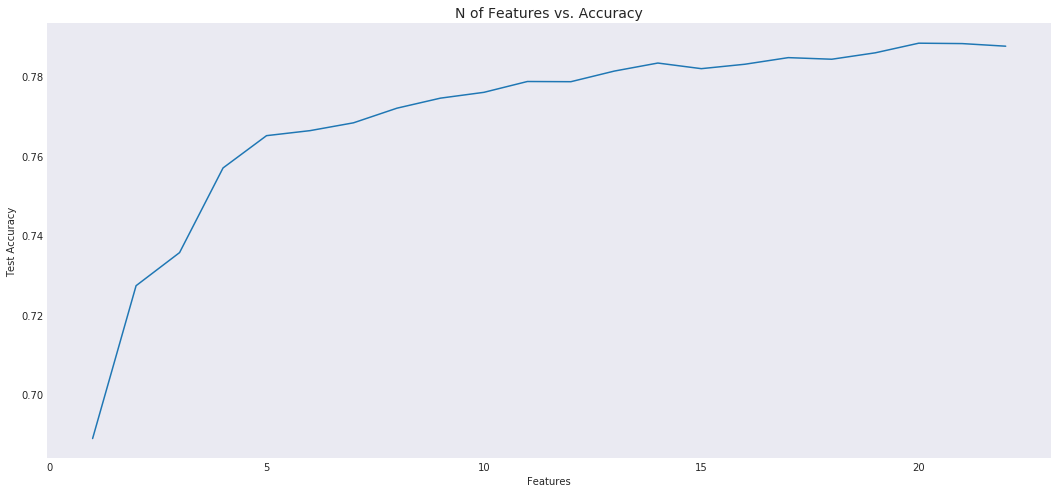

In [134]:
plt.figure(figsize=(18,8))

plt.plot(range(1,(len(features)+1)), scores)
plt.xlabel('Features')
plt.ylabel('Test Accuracy')
plt.title('N of Features vs. Accuracy',size=14)

### 6. RandomForest: top 10 features

In [135]:
features = list(features_df['Features'].head(10))

In [136]:
# generate x train and test
X_trn_2 = X_train[features]
X_tst_2 = X_test[features]

In [137]:
parameters = {'max_features':['auto','log2'], 'min_samples_split':np.arange(10, 100, 10)}
randforest = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=123)
rf_model_2 = GridSearchCV(randforest, parameters, cv=kfold)
rf_model_2.fit(X_trn_2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'log2'], 'min_samples_split': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [138]:
rf_model_2.best_params_

{'max_features': 'auto', 'min_samples_split': 70}

In [139]:
rf_model_2.best_score_

0.7800279212150775

In [140]:
best_rf_2 = rf_model_2.best_estimator_
# check performace on test
best_rf_2.score(X_tst_2, y_test)

0.7767685942072863

In [141]:
fill_in_res('RandomForest: top 10 features', best_rf_2.score(X_tst_2, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
5,RandomForest: all features,0.787
6,RandomForest: top 10 features,0.777


In [142]:
features = X_trn_2.columns
feature_importances = best_rf_2.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
0,rewards_count,0.367359
1,goal,0.186821
3,staff_pick,0.132201
2,launch_cci,0.124591
4,project_length,0.059828
5,blurb_compound,0.047053
6,category_publishing,0.027060
7,first_time_proj,0.020107
9,category_music,0.018358
8,category_technology,0.016622


In [143]:
y_pred_rf_2 = best_rf_2.predict(X_tst_2)

In [144]:
print(metrics.classification_report(y_test,y_pred_rf_2))

             precision    recall  f1-score   support

          0       0.81      0.76      0.79     10640
          1       0.74      0.79      0.77      9178

avg / total       0.78      0.78      0.78     19818



### 7. NaiveBayes & LogisticRegression

In [145]:
# continuous features
cont_features = ['goal','project_length','rewards_count','launch_cci','blurb_compound']
# binary features
binary_features = ['staff_pick','first_time_proj']
binary_features.extend(gen_categories)

In [146]:
# generate x train and test for Gaussian 
X_trn_g = X_train[cont_features]
X_tst_g = X_test[cont_features]

# generate x train and test for Bernoulli
X_trn_b = X_train[binary_features]
X_tst_b = X_test[binary_features]

In [147]:
# fit NB Gaussian
NB_gaus = naive_bayes.GaussianNB()
NB_gaus.fit(X_trn_g, y_train)

GaussianNB(priors=None)

In [148]:
# fit NB Gaussian
NB_bern = naive_bayes.BernoulliNB()
NB_bern.fit(X_trn_b, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [149]:
# Gaussian
y_train_proba_G = NB_gaus.predict_proba(X_trn_g)
y_test_proba_G = NB_gaus.predict_proba(X_tst_g)
# Bernoulli
y_train_proba_B = NB_bern.predict_proba(X_trn_b)
y_test_proba_B = NB_bern.predict_proba(X_tst_b)

In [150]:
X_train_bayes = pd.DataFrame({'guas':y_train_proba_G[:,1], 'bern':y_train_proba_B[:,1]})
X_test_bayes = pd.DataFrame({'guas':y_test_proba_G[:,1], 'bern':y_test_proba_B[:,1]})

In [151]:
# test different C values on logistics regression
parameters = {'C': np.arange(0.001, 10, 0.5)}
logr = LogisticRegression(random_state = 101) 
log_model_NB = GridSearchCV(logr, parameters,cv=kfold)
log_model_NB.fit(X_train_bayes, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 5.010e-01, 1.001e+00, 1.501e+00, 2.001e+00, 2.501e+00,
       3.001e+00, 3.501e+00, 4.001e+00, 4.501e+00, 5.001e+00, 5.501e+00,
       6.001e+00, 6.501e+00, 7.001e+00, 7.501e+00, 8.001e+00, 8.501e+00,
       9.001e+00, 9.501e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [152]:
log_model_NB.best_params_

{'C': 1.001}

In [153]:
log_model_NB.best_score_

0.6818831682169109

In [154]:
best_log_model_NB = log_model_NB.best_estimator_
# check performace on holdout
best_log_model_NB.score(X_test_bayes, y_test)

0.6793823796548593

In [155]:
fill_in_res('LogReg: Bayes Combo', best_log_model_NB.score(X_test_bayes, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
5,RandomForest: all features,0.787
6,RandomForest: top 10 features,0.777
7,LogReg: Bayes Combo,0.679


### 8. KNN: Top features that overlap in LogReg and RF

In [156]:
# test KNN model with features that appeared to be the most important ones 
# in both Logistic Regressiona and Random Forest

features = ['goal',
'launch_cci',
'project_length',
'rewards_count',
'staff_pick',
'first_time_proj',
'category_music',
'category_publishing']

# generate X train and test
X_train_std_5 = get_X_std(X_train, features)
X_test_std_5 = get_X_std(X_test, features)

In [157]:
parameters = {'n_neighbors': np.arange(5, 35)}
knn = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_model = GridSearchCV(knn, parameters,cv=kfold)
knn_model.fit(X_train_std_5, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=101, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [158]:
knn_model.best_params_

{'n_neighbors': 25}

In [159]:
knn_model.best_score_

0.749634164802449

In [160]:
best_knn = knn_model.best_estimator_
# check performace on test
best_knn.score(X_test_std_5, y_test)

0.7478050257341811

In [161]:
fill_in_res('Knn: top 8 features', best_knn.score(X_test_std_5, y_test))

,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
5,RandomForest: all features,0.787
6,RandomForest: top 10 features,0.777
7,LogReg: Bayes Combo,0.679
8,Knn: top 8 features,0.748


### Model Comparison

In [162]:
# generate predictions for all models to be ploted 


# RandomForest: all features
y_score_rf_1 = best_rf_1.predict_proba(X_tst_1)[:,1]
fpr1, tpr1,_ = roc_curve(y_test, y_score_rf_1)
roc_auc1 = auc(fpr1, tpr1)

# RandomForest: top 10 featuers
y_score_rf_2 = best_rf_2.predict_proba(X_tst_2)[:,1]
fpr2, tpr2,_ = roc_curve(y_test, y_score_rf_2)
roc_auc2 = auc(fpr1, tpr1)

# Log_reg: with ALL features
y_score_log_3 =best_log_3.predict_proba(X_test_std_3)[:,1]
fpr3, tpr3,_ = roc_curve(y_test, y_score_log_3)
roc_auc3 = auc(fpr3, tpr3)

# Log_reg: top 10 features
y_score_log_4 =best_log_4.predict_proba(X_test_std_4)[:,1]
fpr4, tpr4,_ = roc_curve(y_test, y_score_log_4)
roc_auc4 = auc(fpr4, tpr4)

# KNN 


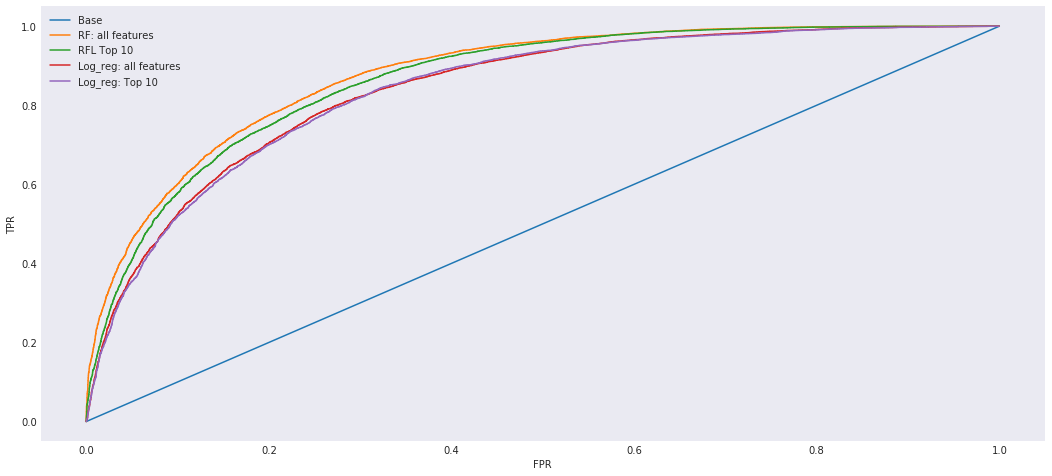

In [163]:
plt.figure(figsize=(18,8))

# plot baseline
plt.plot([0,1],[0,1])

plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.plot(fpr3,tpr3)
plt.plot(fpr4,tpr4)

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend(['Base','RF: all features', 'RFL Top 10', 'Log_reg: all features', 'Log_reg: Top 10'])

In [164]:
print('RF: all features:     ', round(roc_auc1,4))
print('RFL Top 10:           ', round(roc_auc2,4))
print('Log_reg: all features:', round(roc_auc3,4))
print('Log_reg: Top 10       ', round(roc_auc4,4))

RF: all features:      0.8767
RFL Top 10:            0.8767
Log_reg: all features: 0.8408
Log_reg: Top 10        0.8387


### Try Enemble on RF, LogReg and KNN

In [165]:
features = ['goal',
'launch_cci',
'project_length',
'rewards_count',
'staff_pick',
'first_time_proj',
'category_music',
'category_publishing']

# generate X train and test
X_train_std_6 = get_X_std(X_train, features)
X_test_std_6 = get_X_std(X_test, features)

In [166]:
#Logistic
log_reg = log_model_4.best_estimator_

# RandomForest
rf = rf_model_2.best_estimator_

#KNN
knn = neighbors.KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

eclf = VotingClassifier(estimators=[('lr', log_reg), ('rf', rf), ('knn', knn)], voting='hard')
eclf = eclf.fit(X_train_std_6, y_train)

In [167]:
eclf.score(X_train_std_6, y_train)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7843674835584411

In [168]:
eclf.score(X_test_std_6, y_test)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7647593097184378

In [169]:
fill_in_res('Ensemble: RF, LogR, KNN', eclf.score(X_test_std_6, y_test))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,model,test_accuracy
0,Baseline,0.537
1,Log_reg: three base features,0.635
2,Log_reg: with rewards_count,0.745
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
5,RandomForest: all features,0.787
6,RandomForest: top 10 features,0.777
7,LogReg: Bayes Combo,0.679
8,Knn: top 8 features,0.748
9,"Ensemble: RF, LogR, KNN",0.765


In [170]:
model_results.sort_values(by='test_accuracy', ascending=False)

,model,test_accuracy
5,RandomForest: all features,0.787
6,RandomForest: top 10 features,0.777
9,"Ensemble: RF, LogR, KNN",0.765
3,Log_reg: with ALL features,0.759
4,Log_reg: top 10 features,0.756
8,Knn: top 8 features,0.748
2,Log_reg: with rewards_count,0.745
7,LogReg: Bayes Combo,0.679
1,Log_reg: three base features,0.635
0,Baseline,0.537
